In [1]:
df = read.csv('medicaid_costs_for_graphics.csv')

library(dplyr)
library(ggplot2)
library(repr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Get data in correct format

In [2]:
df$drug_spending = df$drug_spending %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$drug_rebates = df$drug_rebates %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$spending_less_rebates = df$spending_less_rebates %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$medicaid_state = df$medicaid_state %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$medicaid_federal = df$medicaid_federal %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$medicaid_total = df$medicaid_total %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$all_spending_state = df$all_spending_state %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$all_spending_federal = df$all_spending_federal %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$all_spending_total = df$all_spending_total %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$drugs_as_share_of_medicaid = df$drugs_as_share_of_medicaid %>% sub('\\%','',.) %>% as.character(.) %>% as.numeric(.)
df$medicaid_as_share_of_all_spending = df$medicaid_as_share_of_all_spending %>% sub('\\%','',.) %>% as.character(.) %>% as.numeric(.)

In [3]:
df$medicaid_percent_total = (df$medicaid_total / df$all_spending_tota) * 100 %>% round(., digits = 2)
df$medicaid_percent_state = (df$medicaid_state / df$all_spending_state) * 100 %>% round(., digits = 2)

In [4]:
head(df)

period_covered,st_abbreviation,st_name,drug_spending,drug_rebates,spending_less_rebates,medicaid_state,medicaid_federal,medicaid_total,all_spending_state,all_spending_federal,all_spending_total,drugs_as_share_of_medicaid,medicaid_as_share_of_all_spending,medicaid_percent_total,medicaid_percent_state
2016,AK,Alaska,108594349,-53673099,54921250,636190900,1066381900,1702572800,6754772879,3277197749,10031970628,3.23,16.97,16.97147,9.418391
2016,AL,Alabama,667346361,-391980305,275366056,1961000000,4393000000,6354000000,16203000000,9635000000,25838000000,4.33,24.59,24.59169,12.102697
2016,AR,Arkansas,339785707,-204345993,135439714,1478700000,5077000000,6555700000,16562824000,7397700000,23960524000,2.07,27.36,27.36042,8.927825
2016,AZ,Arizona,1246118344,-604294056,641824288,2831000000,8690000000,11521000000,25515000000,14167000000,39682000000,5.57,29.03,29.03331,11.095434
2016,CA,California,8004575487,-4277024489,3727550998,28323000000,53337000000,81660000000,160209000000,90690000000,250899000000,4.56,32.55,32.54696,17.678782
2016,CO,Colorado,908800937,-453282840,455518097,3603000000,5382000000,8985000000,27210000000,9517000000,36727000000,5.07,24.46,24.46429,13.241455


In [5]:
options(repr.plot.width = 10, repr.plot.height = 6)

Total spending by state over time

In [6]:
temp = df %>%
    group_by(period_covered,st_abbreviation) %>%
    select(period_covered,st_abbreviation,medicaid_state) %>%
    filter(period_covered == 2006)

temp = temp[c(2:3)]
colnames(temp) = c('st_abbreviation', 'baseline')

df = full_join(df, temp, by = 'st_abbreviation')

In [7]:
df$pct_change_2006 = ((df$medicaid_state - df$baseline)/df$baseline)*100

avg_change = df %>% group_by(period_covered) %>% summarise(pct_change_2006 = mean(pct_change_2006, na.rm = TRUE))

Warning message:
“Removed 1 rows containing missing values (geom_text).”

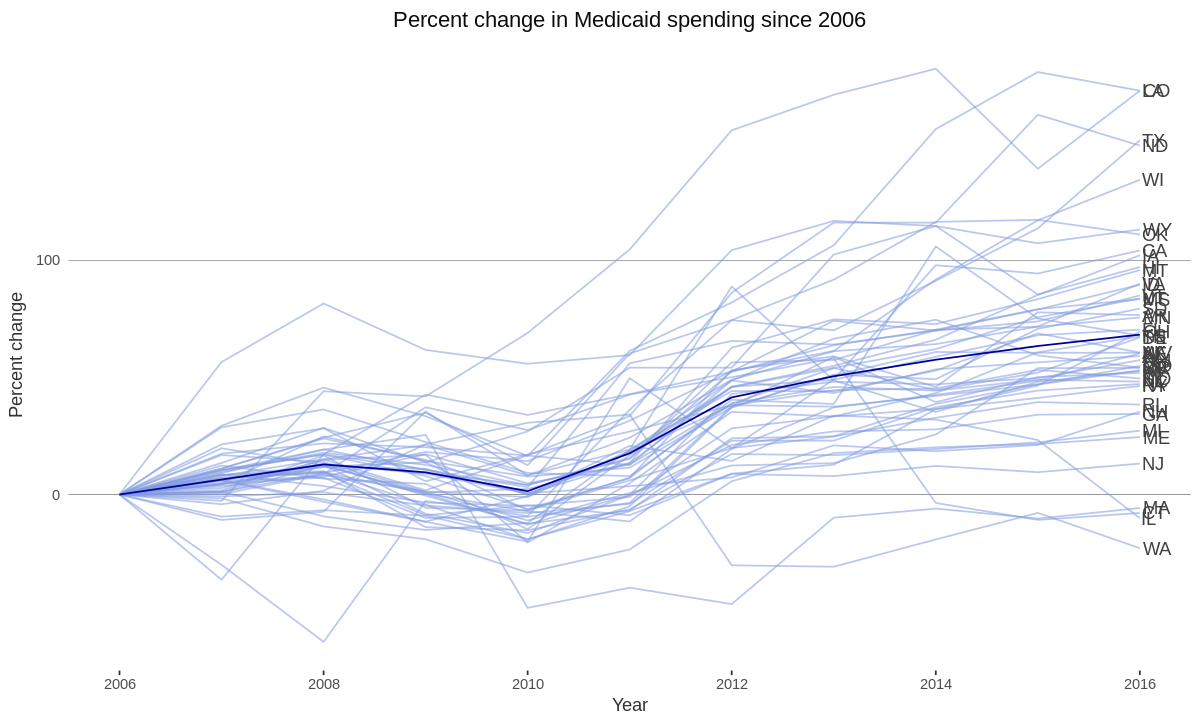

In [8]:
ggplot(df, aes(period_covered,pct_change_2006)) +
  geom_line(aes(alpha = .4, group = st_abbreviation), color = '#829be0') +
  geom_text(data = df[df$period_covered == max(df$period_covered),],
            aes(label = st_abbreviation),
            color = 'gray25',
            hjust = -.1) +
  theme(legend.position = 'none',
        panel.background = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(color = 'black', size = .1),
        axis.title.x = element_text(color = 'gray20'),
        axis.title.y = element_text(color = 'gray20'),
        plot.title = element_text(colour = 'gray5', vjust = .5, hjust = 0.5)) +
  xlab('Year') +
  ylab('Percent change') +
  ggtitle('Percent change in Medicaid spending since 2006') +
  geom_line(data = avg_change, color = '#000099')

Export national average data to JSON

In [16]:
medicaid_spending = df %>%
    group_by(period_covered) %>%
    summarise(medicaid_share = mean(medicaid_as_share_of_all_spending),
              drug_share = mean(drugs_as_share_of_medicaid),
              drug_sum = sum(spending_less_rebates))

In [20]:
medicaid_spending$drug_sum/1000000000 %>% round(., digits = 2)

[1]  1.600350  9.312055 15.181533 15.169752 19.996004 19.756235 18.128296
 [8] 17.066124 24.195784 27.826383 26.387377

In [11]:
library(rjson)

Let's graph medicaid as a share of all spending

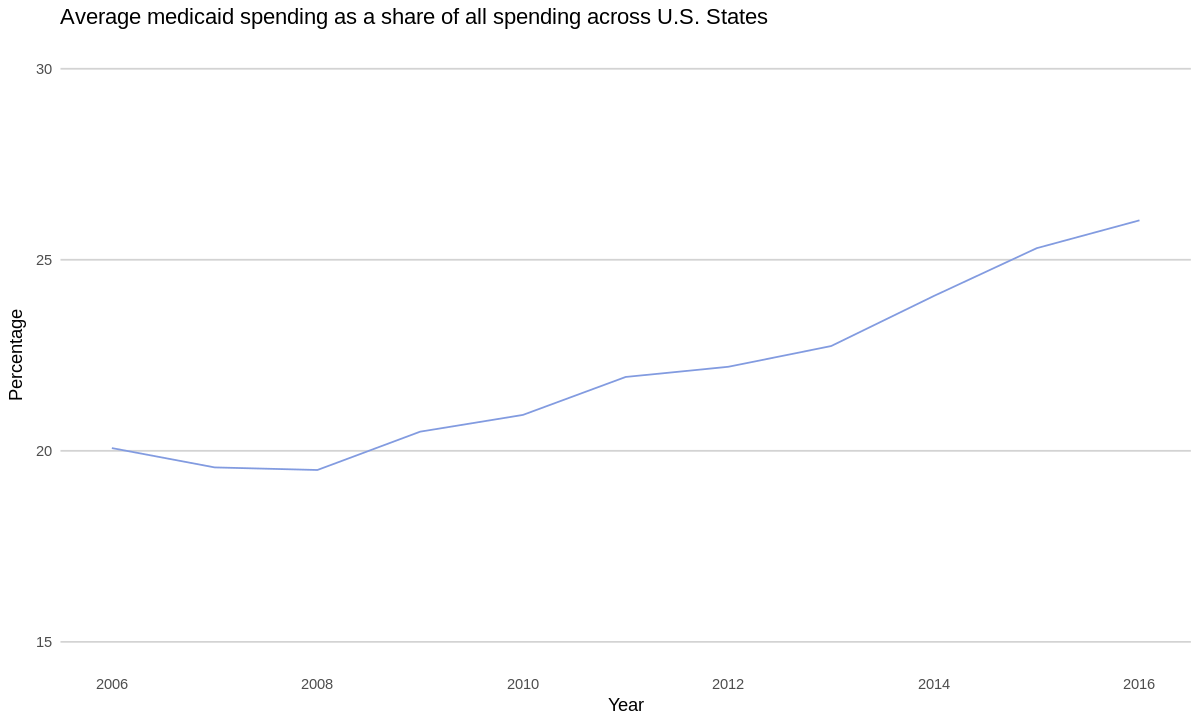

In [12]:
ggplot(medicaid_spending,aes(period_covered,medicaid_share)) +
    geom_line(color = '#829be0') +
    xlab('Year') +
    ylab('Percentage') +
    ggtitle('Average medicaid spending as a share of all spending across U.S. States') +
    ylim(c(15,30)) +
    theme(panel.background = element_blank(),
          panel.grid.major.y = element_line(color = 'lightgrey'),
          panel.grid.major.x = element_blank(),
          axis.ticks = element_blank())

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'period_covered' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(capture.output(print(obj)), collapse = "\n")
10. capture.output(print(obj))
11. evalVis(expr)
12. withVisible(eval(expr, pf))
13. eval(expr, pf)
14. eval(expr, pf)
15. print(obj)
16. print.ggplot(obj)
17. ggplot_build(x)
18. by_layer(function(l, d) 

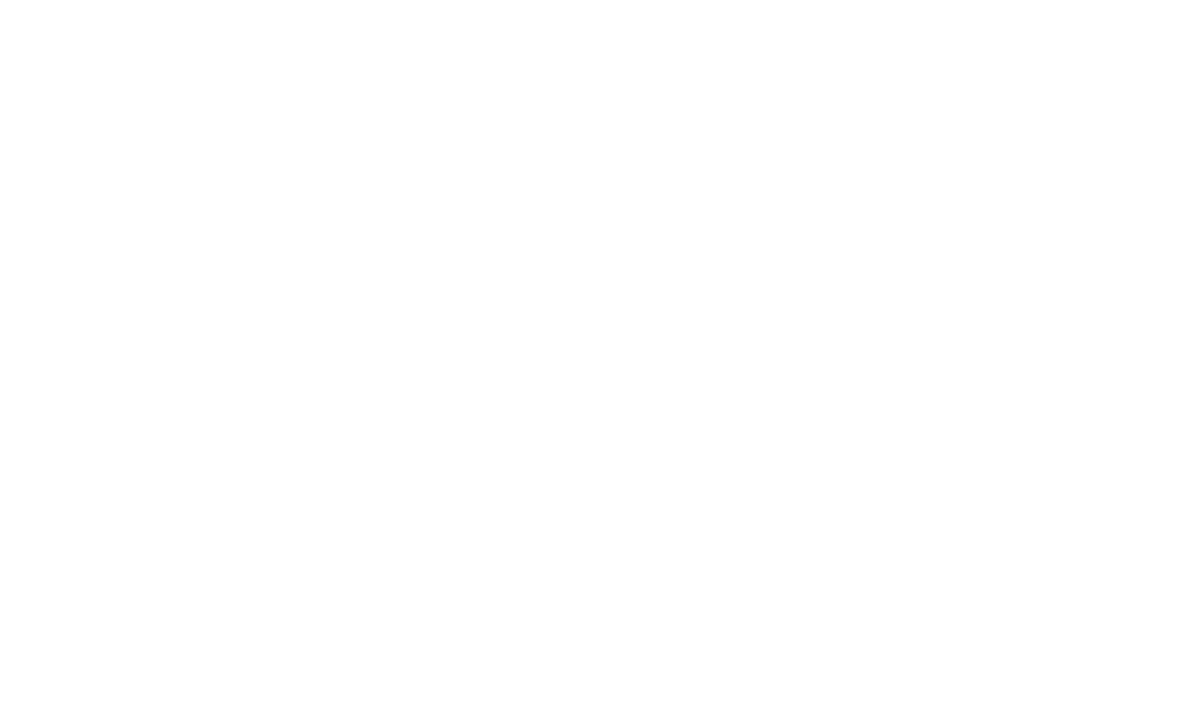

In [13]:
ggplot(temp,aes(period_covered,drug_share)) +
    geom_line(color = '#829be0') +
    xlab('Year') +
    ylab('Percentage') +
    ggtitle('Average drug spending as a share of medicaid across U.S. States') +
    ylim(c(0,10)) +
    theme(panel.background = element_blank(),
          panel.grid.major.y = element_line(color = 'lightgrey'),
          panel.grid.major.x = element_blank(),
          axis.ticks = element_blank())

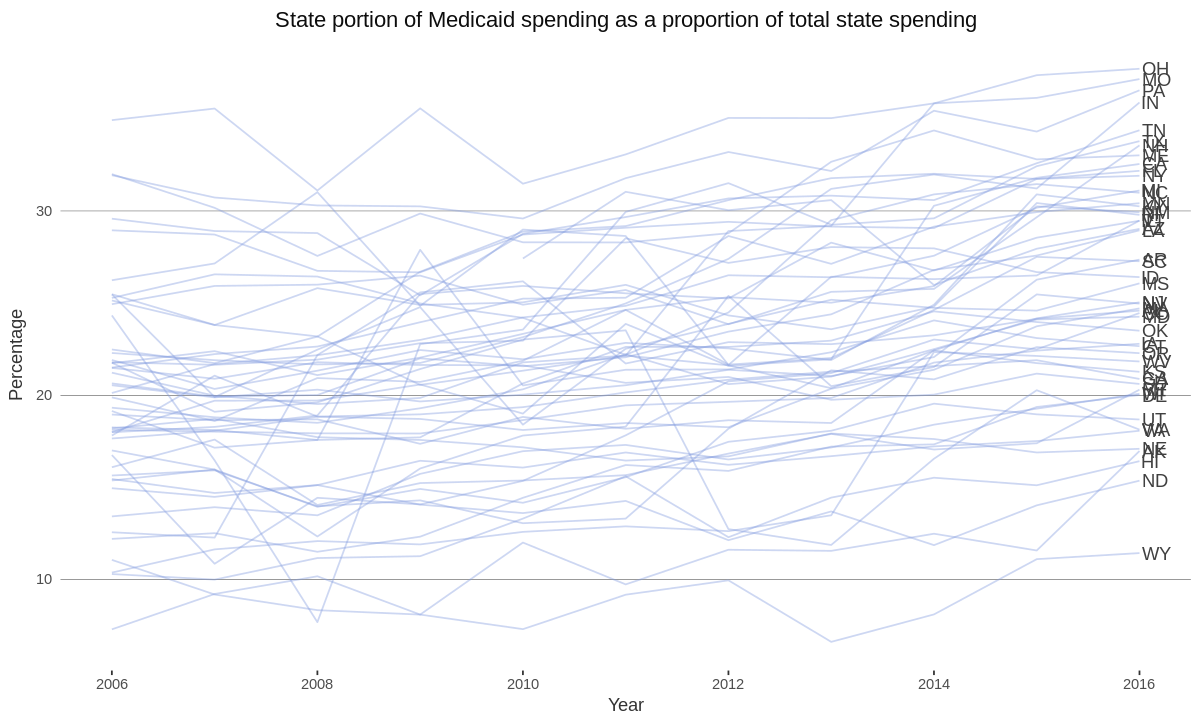

In [14]:
ggplot(df,aes(period_covered,medicaid_as_share_of_all_spending)) +
    geom_line(color = '#829be0',alpha=0.4,aes(group=st_abbreviation)) +
    xlab('Year') +
    ylab('Percentage') +
    ggtitle('State portion of Medicaid spending as a proportion of total state spending') +
    geom_text(data = df[df$period_covered == max(df$period_covered),],
            aes(label = st_abbreviation),
            color = 'gray25',
            hjust = -.1) +
    theme(legend.position = 'none',
        panel.background = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(color = 'black', size = .1),
        axis.title.x = element_text(color = 'gray20'),
        axis.title.y = element_text(color = 'gray20'),
        plot.title = element_text(colour = 'gray5', vjust = .5, hjust = 0.5))

What about average cost of drug spending?

In [15]:
temp = df %>%
    group_by(period_covered) %>%
    summarise(avg_drug_spending = mean(spending_less_rebates))

temp$avg_drug_spending/1000000

[1]  32.66019 190.04193 309.82721 309.58678 399.92008 395.12471 362.56592
 [8] 341.32248 483.91567 556.52767 527.74754